## Create and test ion channel model

In [2]:
from experiments.ina_sakakibara import (sakakibara_iv,
                                        sakakibara_iv_Nao2 ,
                                        sakakibara_iv_Nao5 ,
                                        sakakibara_iv_Nao20 ,
                                        sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_1,
                                        sakakibara_inact_kin_2,
                                        sakakibara_inact_kin_80,
                                        sakakibara_inact_kin_100,
                                        sakakibara_recov,
                                        sakakibara_recov_100,
                                        sakakibara_recov_kin)
from experiments.ina_schneider import (schneider_iv,
                                    schneider_tauf,
                                    schneider_taum,
                                    schneider_taus,
                                      schneider_inact,
                                       schneider_inact_128,
                                      schneider_reduc,
                                       schneider_reduc_95,
                                      schneider_recov,
                                      schneider_recov_95)


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyabc import Distribution, RV
import os, tempfile
import logging
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from pyabc import History
from ionchannelABC import plot_sim_results
import seaborn as sns
from ionchannelABC import plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.4


In [3]:
modelfile = 'models/Courtemanche_iNa.mmt'

In [4]:
observations, model, summary_statistics = setup(modelfile,
                                                schneider_recov_95)
assert len(observations)==len(summary_statistics(model({})))

## Set limits and generate uniform initial priors

In [5]:
#gate selector variable
gate = 'h'

if gate == 'h':
    limits = {
              'ina.g_Na' : (0.01,100),
              'ina.c1_h': (0,50),
              'ina.a1_h': (0.1,10),
              'ina.a2_h': (0,20),
              'ina.a3_h': (0,100),
              'ina.b1_h': (0,10),
              'ina.b2_h': (0,100),
              'ina.b3_h': (0,50),
              'ina.b4_h': (0,20),
              'ina.b5_h': (0.0001,1),
              'ina.b6_h': (0.000001,0.001),
              'ina.b7_h': (0,1)}

elif gate =='m':
    limits = {'ina.g_Na' : (0.01,100),
              'ina.a1_m': (0,100),
              'ina.a2_m': (-50,50),
              'ina.a3_m': (-50,50),
              'ina.a4_m': (-50,50),
              'ina.b1_m': (-50,50),
              'ina.b2_m': (0,100)}

elif gate == 'j':
    limits = {'ina.g_Na' : (0.01,100),
              'ina.c1_j': (0,100),
              'ina.a1_j': (100000,300000),
              'log_ina.a2_j': (-4,1),
              'log_ina.a3_j': (-6,-3),
              'log_ina.a4_j': (-4,0),
              'ina.a5_j': (0,50),
              'ina.a6_j': (0.001,10),
              'ina.a7_j': (50,150),
              'ina.b1_j': (0.001,10),
              'log_ina.b2_j': (-8,-5),
              'log_ina.b3_j': (-3,1),
              'ina.b4_j': (0,50),
              'log_ina.b5_j': (-4,0),
              'log_ina.b6_j': (-4,0),
              'log_ina.b7_j': (-4,0),
              'ina.b8_j': (20,70)}

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})


In [6]:
print(limits)

{'ina.g_Na': (0.01, 100), 'ina.c1_h': (0, 50), 'ina.a1_h': (0.1, 10), 'ina.a2_h': (0, 20), 'ina.a3_h': (0, 100), 'ina.b1_h': (0, 10), 'ina.b2_h': (0, 100), 'ina.b3_h': (0, 50), 'ina.b4_h': (0, 20), 'ina.b5_h': (0.0001, 1), 'ina.b6_h': (1e-06, 0.001), 'ina.b7_h': (0, 1)}


## Run ABC calibration

In [7]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "crm_ina_testing_gate_"+gate+".db"))

In [8]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [42]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 2048 particles


In [43]:

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(10000), # Small pop to test
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=40),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9999999999999998, '1': 0.9999999999999998, '2': 0.9999999999999998, '3': 0.9999999999999998, '4': 0.9999999999999998, '5': 0.9999999999999998, '6': 0.9999999999999998, '7': 0.9999999999999998, '8': 0.9999999999999998, '9': 0.9999999999999998, '10': 0.9999999999999998, '11': 0.9999999999999998, '12': 0.9999999999999998, '13': 0.9999999999999998, '14': 0.9999999999999998, '15': 0.9999999999999998, '16': 0.9999999999999998, '17': 0.9999999999999998, '18': 0.9999999999999998}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=20, quantile_multiplier=1


In [44]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [45]:
#abc.load(db_path,3)

In [46]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=11, start_time=2019-09-12 14:22:17.422954, end_time=None)>


In [47]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10, min_acceptance_rate=0.005)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 10622
DEBUG:Epsilon:new eps, t=1, eps=2.3148087145111815
INFO:ABC:t:1 eps:2.3148087145111815
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 31552
DEBUG:Epsilon:new eps, t=2, eps=2.314676537120189
INFO:ABC:t:2 eps:2.314676537120189
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 71457
DEBUG:Epsilon:new eps, t=3, eps=2.3145644195445763
INFO:ABC:t:3 eps:2.3145644195445763
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 148376
DEBUG:Epsilon:new eps, t=4, eps=2.3144358970029555
INFO:ABC:t:4 eps:2.3144358970029555
DEBUG:ABC:now submitting population 4
Process Process-640:
Process Process-632:
Process Process-621:
Process Process-615:
Process Process-605:
Process Process-60

KeyboardInterrupt: 

  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/transitionmeta.py", line 28, in pdf
    return f(self, x)
  File "/home/brm18/.local/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/utils.py", line 58, in rvs
    return self.rvs_single()
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/smc.py", line 651, in _evaluate_proposal
    x_0)
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/transitionmeta.py", line 37, in rvs_single
    return f(self)
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/transitionmeta.py", line 28, in pdf
    return f(self, x)
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/transitionmeta.py", line 37, in rvs_single
    return f(self)
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/multiprocessing/process.py",

Traceback (most recent call last):
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/brm18/.local/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/experiment.py", line 235, in summary_statistics
    for i, val in enumerate(sum_stats_combined(data))}
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/smc.py", line 706, in _calc_proposal_weight
    pd.Series(dict(theta_ss)))
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/smc.py", line 706, in _calc_proposal_weight
    pd.Series(dict(theta_ss)))
  File "/home/brm18/.local/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/utils.py", line 58, in rvs
    return self.rvs_single()
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/site-package

  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 30, in work
    new_sim = simulate_one()
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/multivariatenormal.py", line 85, in <listcomp>
    for xs in x])
Traceback (most recent call last):
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/site-packages/pandas/core/generic.py", line 4830, in sample
    if (weights == np.inf).any() or (weights == -np.inf).any():
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/multivariatenormal.py", line 85, in <listcomp>
    for xs in x])
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/transitionmeta.py", line 37, in rvs_single
 

  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/site-packages/pandas/core/internals/blocks.py", line 3060, in get_block_type
    elif is_interval_dtype(dtype) or is_period_dtype(dtype):
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/model.py", line 117, in summary_statistics
    sum_stats = sum_stats_calculator(raw_data)
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/random_variables.py", line 189, in pdf
    return self.distribution.pdf(x, *args, **kwargs)
  File "/home/brm18/.local/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/utils.py", line 58, in rvs
    return self.rvs_single()
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/site-packages/pandas/core/computation/expressions.py", line 100, in _evaluate_numexpr
    if _can_use_numexpr(op, op_str, a, b, 'evaluate'):
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/smc.py", line 545, in simulate_one
    transitions)
KeyboardInterrupt
  File "/apps/anacond

  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/transitionmeta.py", line 37, in rvs_single
    return f(self)
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/multivariatenormal.py", line 76, in rvs_single
    np.zeros(self.cov.shape[0]), self.cov))
  File "mtrand.pyx", line 4535, in mtrand.RandomState.multivariate_normal
  File "/home/brm18/.local/lib/python3.7/site-packages/scipy/linalg/decomp_svd.py", line 16, in svd
    def svd(a, full_matrices=True, compute_uv=True, overwrite_a=False,
KeyboardInterrupt
KeyboardInterrupt
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/multivariatenormal.py", line 73, in rvs_single
    sample = self.X.sample(weights=self.w).iloc[0]
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/multivariatenormal.py", line 85, in <listcomp>
    for xs in x])
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/site-packages/numpy/core/numeric.py", line 541, in asanyarra

# Results analysis

/apps/anaconda/anaconda3-2019.07/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


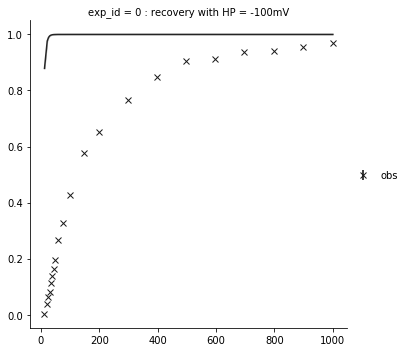

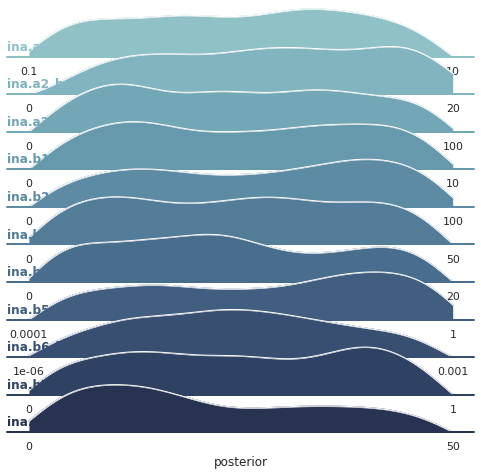

In [9]:
history = History(db_path)
history.id = 4

#Sakakibara experiments :

# IV corresponds to sakakibara_iv,
# act corresponds to sakakibara_act,
# inact corresponds to sakakibara_inact
# time constants corresponds to sakakibara_inact_kin_1
# recovery corresponds to sakakibara_recov_100
# availablity corresponds to sakakibara_inact_kin_80


# history.id correspondance (with gate correspondance) :

# 2 corresponds to the recovery : j gate : success
# 4 corresponds to the recovery : h gate : fail : eps = 2.90 (2 iter with eps constant) 
# 6 corresponds to the recovery : m gate : fail : eps = 2.90 (3 iter with eps constant)

# 3 : corresponds to the availability : j gate, but failed to retrieve a correct curve
# 3 : corresponds to the availability : h gate, still running : stopped, doesn't run, see next 2 lines
# 5 : corresponds to the availability : m gate, still running :
# stoped after 3h without improvement (128 particles and still submitting population 0)

# 4 corresponds to the time constants : j gate :fail, the bi exp = 2*(1/2*exp) : eps = 1.17 (10 iter)
# 5 corresponds to the time constants : h gate :fail, the bi exp = 2*(1/2*exp) : eps = 1.21 (20 iter)
# 7 corresponds to the time constants : m gate : fail : eps = 0.49 (20 iter) pop 100
# 8 corresponds to the time constants : m gate : fail : eps = 0.57 (10 iter) pop 1000

# 5 corresponds to the IV,Act,Inact ('ina.g_Na' : (0.01,100) has been added to the priors) : j gate : 
# eps = 0.64 (10 iter)
# 6 corresponds to the IV,Act,Inact ('ina.g_Na' : (0.01,100) has been added to the priors) : h gate : 
# eps = 0.54 (22 iter) Fail inact only after 10 iter but sucess after 20 ! weird it's the inactivation gate 
# 9 corresponds to the IV,Act,Inact ('ina.g_Na' : (0.01,100) has been added to the priors) : m gate : 
#: eps = 0.675 (10 iter) Fail inact only after 20 iter



# Schneider experiments:

# IV corresponds to schneider_iv,
# inact corresponds to schneider_inact_128
# availability corresponds to schneider_reduc_95
# recovery corresponds to schneider_recov_95


# history.id correspondance (with gate correspondance) :

# 6 corresponds to the IV : j gate : success : eps = 0.41 (12 iter)
# 7 corresponds to the IV : h gate : sucess : eps = 0.45 (20 iter)
# 10 corresponds to the IV : m gate : sucess : eps = 0.19 (20 iter)

# 7 corresponds to the inact : j gate : success : eps = 0.39 (10 iter)
# 9 corresponds to the inact : h gate : fail : eps = 3.31 (10 iter) eps is cst.
# 12 corresponds to the inact : m gate : fail : eps = 3.31 (4 iter) eps is cst

# 8 corresponds to the recovery : j gate : fail : eps = 0.39 (20 iter) : 
# same problem than standard model
# 11 corresponds to the recovery : h gate : fail : eps = 2.30 (4 iter) eps is cst
# 13 corresponds to the recovery : m gate : fail : eps = 2.30 (4 iter) eps is cst

# 9 corresponds to the availability : j gate : fail : eps = 3.5 (10 iter)
# 10 corresponds to the availability : h gate : fail : eps = 7.10 (8 iter) eps is cst.
# 11 corresponds to the availability : m gate : fail : eps = 7.10 (3 iter) eps is cst.
df, w = history.get_distribution(m=0)

grid1 = plot_sim_results(modelfile,sakakibara_recov_100,df=df, w=w) 
grid2 = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)